## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [487]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

from keras.datasets import boston_housing

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

## Baseline Pass

In [488]:
# import data
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [489]:
# Minmax Scaler
Scaler  = MinMaxScaler()

# Normalize the Data
x_train = Scaler.fit_transform(x_train)
x_test  = Scaler.fit_transform(x_test)

In [490]:
# Let's see if a relatively tuned XGBRegessor Beats a NN
xgbr    = XGBRegressor (base_score=0.72, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.13, max_delta_step=0,
                        max_depth=8, min_child_weight=.8, missing=None, n_estimators=180,
                        n_jobs=-1, objective='reg:squarederror',random_state=42, reg_alpha=0, 
                        reg_lambda=1, scale_pos_weight=1,seed=42, silent=True, subsample=1, 
                        eval_metric='rmse', normalize_type='forest')

xgbr.fit(x_train, y_train)

y_pred = xgbr.predict(x_test)



In [491]:
%%time
# Neural Network Parameters
bnn = Sequential()

# Input + First Hidden
bnn.add(Dense(64, input_shape=(13,), activation='relu'))
# Hidden 2
bnn.add(Dense(64, activation='sigmoid'))
# Hidden 3
bnn.add(Dense(32, activation='linear'))
# Output
bnn.add(Dense(1, activation = 'linear'))


# Compile
bnn.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

bnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 64)                896       
_________________________________________________________________
dense_162 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_163 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 33        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________
CPU times: user 110 ms, sys: 3.52 ms, total: 113 ms
Wall time: 114 ms


In [492]:
%%time
# NN Fit
bnn_hist = bnn.fit(x_train, y_train, 
                   epochs=500, 
                   validation_split=.1, 
                   batch_size=128, 
                   verbose=0)

CPU times: user 6.94 s, sys: 742 ms, total: 7.68 s
Wall time: 5.7 s


In [493]:
scores = bnn.evaluate(x_test, y_test)

print('Neural Network MSE   : ', scores[1])
print('Gradient Boosting MSE: ', mean_squared_error(y_pred, y_test))

102/102 [==============================] - 0s 137us/step
Neural Network MSE   :  31.207175161324294
Gradient Boosting MSE:  25.107330178360208


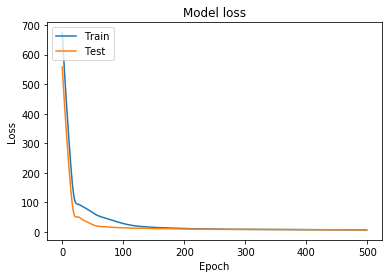

In [494]:
# Plot training & validation loss values
plt.plot(bnn_hist.history['loss'])
plt.plot(bnn_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Second Pass

With limited data preparation, the Gradient Boosting Tree Ensemble outperforms the Neural Network Considerably. 

Here is a list of data cleaning and feature engineering I'll be doing:

> - Outlier Removal

In [495]:
# Re - import data
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [496]:
# Make X_train and X_test into dataframes so I can manipulate them more easily

X_train = pd.DataFrame(x_train, columns=['CRIM', 'ZN', 'INDUS', 
                                        'CHAS', 'NOX', 'RM', 
                                        'AGE', 'DIS', 'RAD', 
                                        'TAX', 'PTRATIO', 'B', 
                                        'LSTAT'])

X_test  = pd.DataFrame(x_test, columns=['CRIM', 'ZN', 'INDUS', 
                                        'CHAS', 'NOX', 'RM', 
                                        'AGE', 'DIS', 'RAD', 
                                        'TAX', 'PTRATIO', 'B', 
                                        'LSTAT'])

In [497]:
X = pd.concat([X_train, pd.DataFrame(y_train, columns = ['MEDV'])], axis =1)
Y = pd.concat([X_test, pd.DataFrame(y_test, columns = ['MEDV'])], axis =1)

Now that the data is in a format that is easier to manipulate, I am going to handle outliers normalize some distributions. Afterwards I am going to pipe the data back up to the Neural Net and Gradient Boosting Models. 

In [498]:
#Remove outliers in target data
X = X[~(X['MEDV'] >= 50.0)]
print(np.shape(X))

(391, 14)


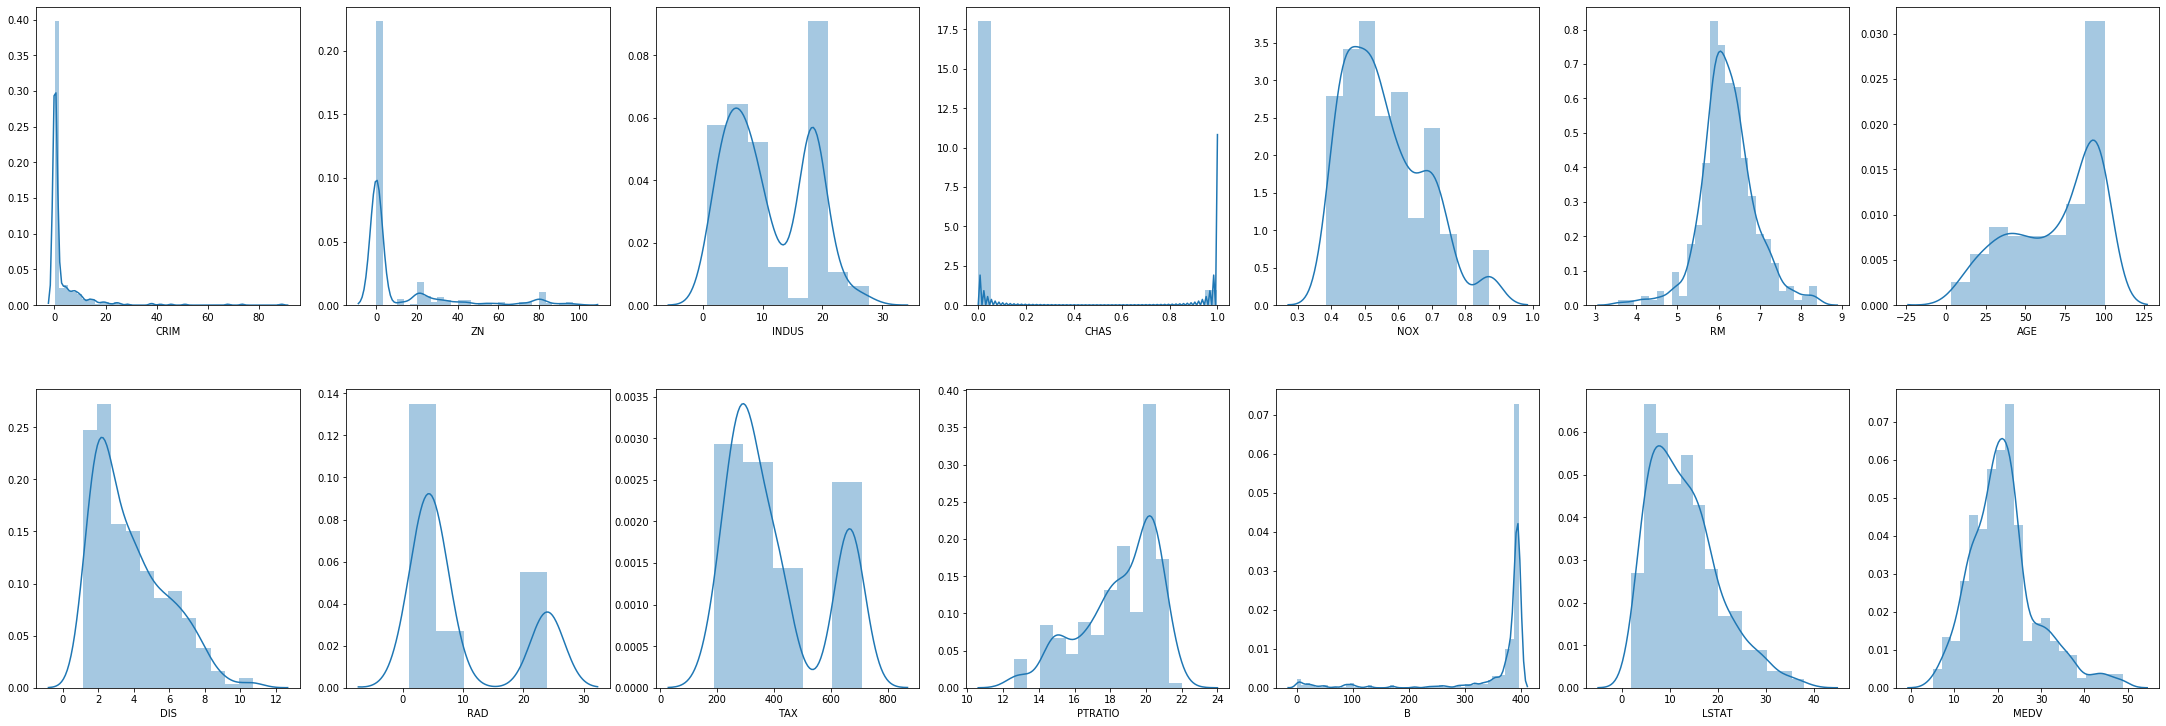

In [499]:
# Looking at my distributions

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(30, 10))
index = 0
axs = axs.flatten()
for k,v in X.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [500]:
# Normalizing Features

log_list = ['CRIM', 'NOX', 'AGE',
            'DIS', 'RAD', 'TAX','B']
for df in [X,Y]:
    for item in log_list:
        # log normalization
        df[item] = np.log(df[item])
    # custom normalization
    df['PTRATIO'] = df['PTRATIO']**5
    # another custom normalization
    df['B'] = df['B']**30

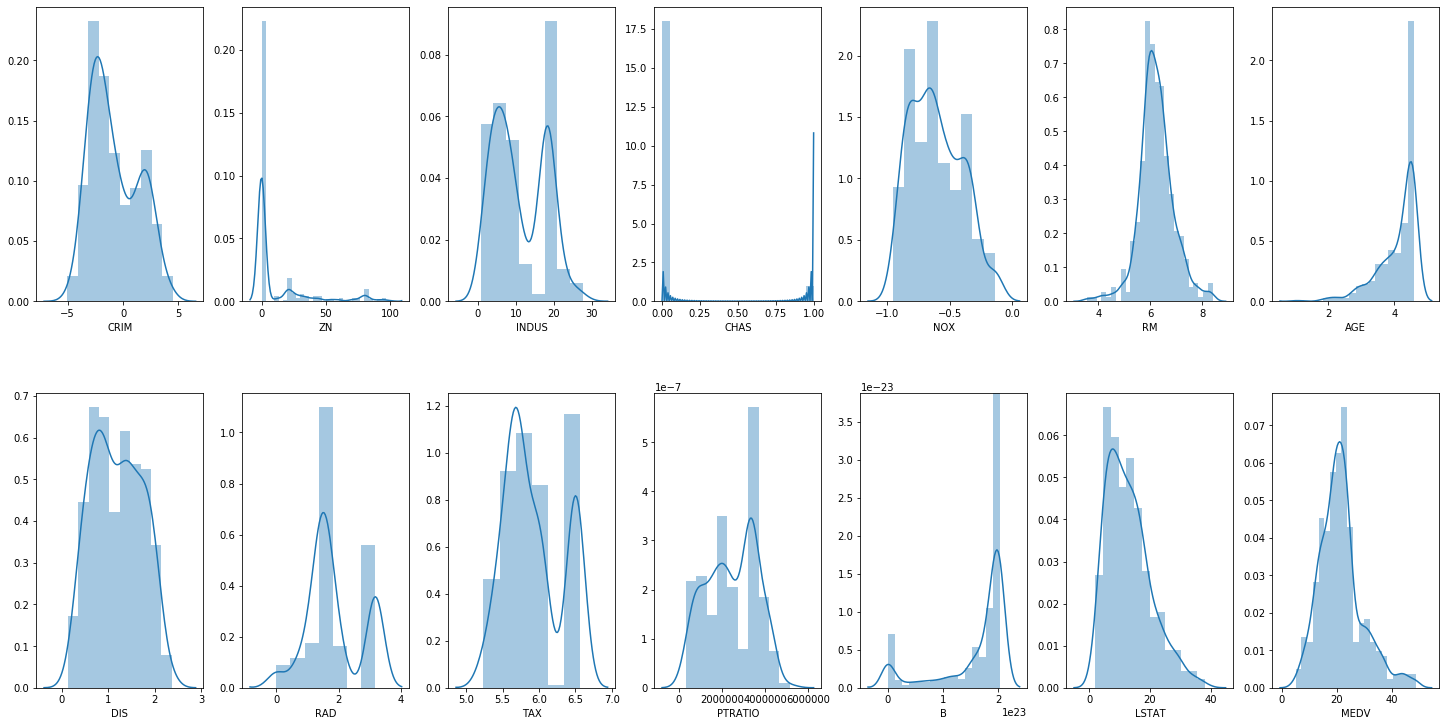

In [501]:
# Modified Distribution

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in X.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

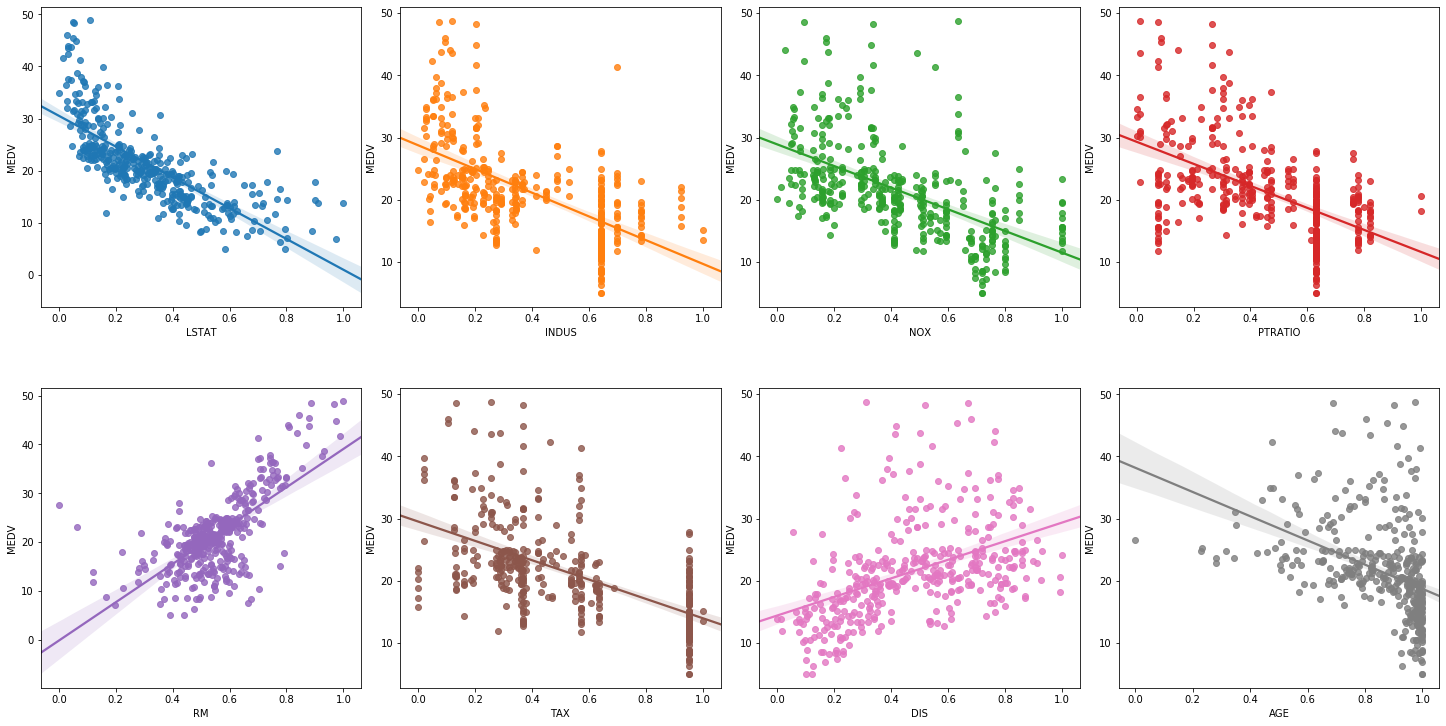

In [502]:
# Checking my work
# The regression lines should fit nicely. 

Scaler = MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = X.loc[:,column_sels]
y = X['MEDV']
x = pd.DataFrame(data=Scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

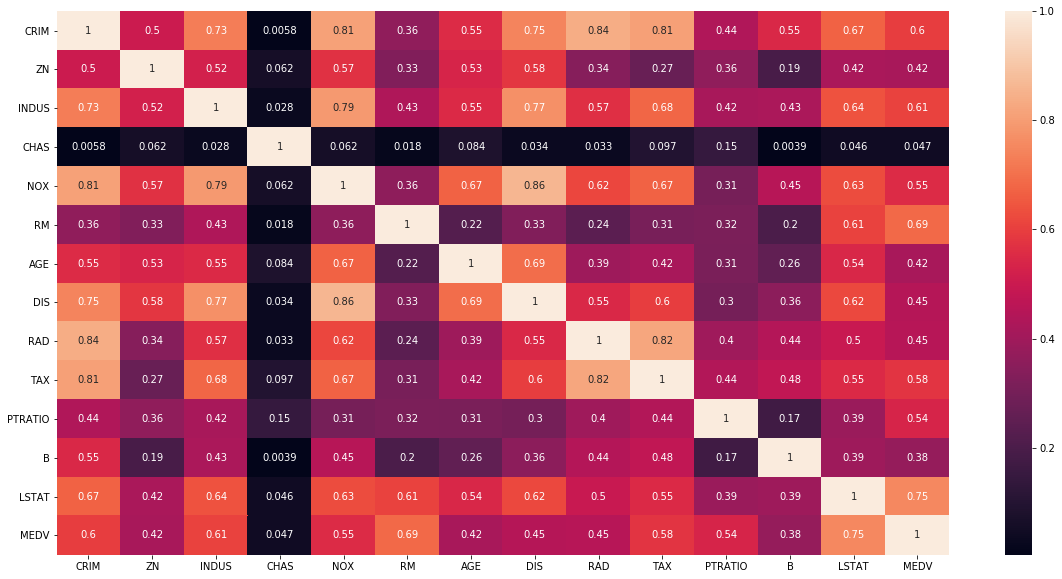

In [503]:
plt.figure(figsize=(20, 10))
sns.heatmap(X.corr().abs(),  annot=True);

In [504]:
# Drop low correlation or highly colinear features. 

X = X.drop(columns=['RAD', 'CHAS'])
Y = Y.drop(columns=['RAD', 'CHAS'])

X_train = X.drop(columns='MEDV').values
y_train  = X['MEDV'].values
X_test = Y.drop(columns='MEDV').values
y_test  = Y['MEDV'].values

In [505]:
# Normalize the Data
X_train = Scaler.fit_transform(X_train)
X_test  = Scaler.fit_transform(X_test)

In [506]:
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

In [507]:
%%time
# Neural Network Parameters
bnn = Sequential()

# Input + First Hidden
bnn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# Hidden 2
bnn.add(Dense(32, activation='sigmoid'))
#Hidden 3
bnn.add(Dense(64, activation='relu'))
# Output
bnn.add(Dense(1, activation = 'linear'))

# Compile
bnn.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

bnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 64)                768       
_________________________________________________________________
dense_166 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_167 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 65        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
CPU times: user 109 ms, sys: 3.93 ms, total: 113 ms
Wall time: 113 ms


In [508]:
scores = bnn.evaluate(X_test, y_test)

print('Neural Network MSE   : ', scores[1])
print('Gradient Boosting MSE: ', mean_squared_error(y_pred, y_test))

102/102 [==============================] - 2s 15ms/step
Neural Network MSE   :  602.2595071231617
Gradient Boosting MSE:  29.271696075953546


Well that was ineffective

### I give up and am going to throw raw data into it. 

In [509]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

xgbr.fit(x_train, y_train)

y_pred = xgbr.predict(x_test)


In [510]:
%%time
# Neural Network Parameters
bnn = Sequential()

# Input + First Hidden
bnn.add(Dense(64, input_shape=(13,), activation='relu'))
# Hidden 2
bnn.add(Dense(64, activation='sigmoid'))
# Hidden 3
bnn.add(Dense(32, activation='linear'))
# Output
bnn.add(Dense(1, activation = 'linear'))


# Compile
bnn.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

bnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 64)                896       
_________________________________________________________________
dense_170 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_171 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_172 (Dense)            (None, 1)                 33        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________
CPU times: user 120 ms, sys: 3.14 ms, total: 123 ms
Wall time: 128 ms


In [511]:
%%time
# NN Fit
bnn_hist = bnn.fit(x_train, y_train, 
                   epochs=500, 
                   validation_split=.1, 
                   batch_size=128, 
                   verbose=0)

CPU times: user 7.06 s, sys: 798 ms, total: 7.86 s
Wall time: 5.81 s


In [512]:
scores = bnn.evaluate(x_test, y_test)

print('Neural Network MSE   : ', scores[1])
print('Gradient Boosting MSE: ', mean_squared_error(y_pred, y_test))

102/102 [==============================] - 0s 72us/step
Neural Network MSE   :  24.926955727969897
Gradient Boosting MSE:  11.94301560123877


![facepalm](https://scifanatic-wpengine.netdna-ssl.com/wp-content/uploads/2017/03/facepalm-head.jpg)

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [538]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

In [539]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [540]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [541]:
batch_size = 128
num_classes = 10
epochs = 100

x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)

# Change dtypes
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# encode target
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [542]:
fashion_mnist_model = Sequential()

# Input first hidden
fashion_mnist_model.add(Dense(64, input_shape=(784,), activation='relu'))
# Hidden 2
fashion_mnist_model.add(Dense(64, activation='relu'))
# Multiclass Output
fashion_mnist_model.add(Dense(10, activation='softmax'))
# Compliler
fashion_mnist_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

fashion_mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_184 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_185 (Dense)            (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


10000/10000 [==============================] - 0s 33us/step
acc: 78.56 




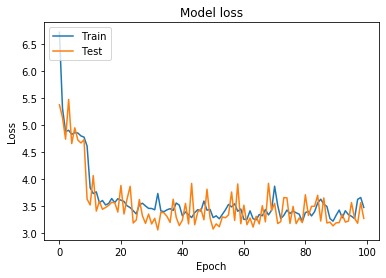

In [543]:
hist_mnist = fashion_mnist_model.fit(x_train, y_train, 
                                     batch_size=batch_size, 
                                     epochs=epochs, 
                                     validation_split=.1, 
                                     verbose=0)

# evaluate the model
scores = fashion_mnist_model.evaluate(x_test, y_test)
print(f"{fashion_mnist_model.metrics_names[1]}: {scores[1]*100}",'\n\n')

plt.plot(hist_mnist.history['loss'])
plt.plot(hist_mnist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

I know I can get a better score with a different model. I watched that 3 Blue 1 Brown Video SEVERAL TIMES. 

Were going with a Convolutional Neural Network

## The most trusted name in Computer Vision

In [544]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [545]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [546]:
cnn_model = Sequential()

# Convolutional Input Layer
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(28,28,1)))

# Convolutional Hidden Layer
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
# Pooling Layer
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout Layer to Reduce Overfitting
cnn_model.add(Dropout(0.25))
# Flattens the model so it fits in the Dense Layer
cnn_model.add(Flatten())
# Dense Hidden Layer
cnn_model.add(Dense(128, activation='relu'))
# More Aggressive Dropout
cnn_model.add(Dropout(0.5))
# Multiclass Output 
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_186 (Dense)            (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [547]:
cnn_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

cnn_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))



NameError: name 'model' is not defined

In [549]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)

scores = cnn_model.evaluate(x_test, y_test)
print(f"{cnn_model.metrics_names[1]}: {scores[1]*100}",'\n\n')

10000/10000 [==============================] - 2s 234us/step
acc: 92.45 




## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.